Dogs vs Cats Kaggle Competition

In [388]:
# Import libs
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow


In [389]:
# defines

DIR_IMG_TRAIN = 'datasets/train/'
DIR_IMG_TEST = 'datasets/test1/'

IMG_SHAPE = (64,64,3)

Image have shape: (144, 175, 3)


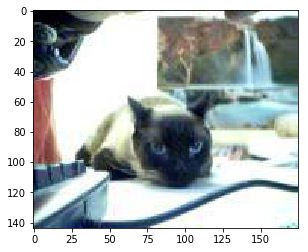

In [322]:
import os
import matplotlib.pyplot as plt
from scipy.ndimage import imread
from scipy.misc import imsave

%matplotlib inline

# cat example
sample_img_path = DIR_IMG_TRAIN+'cat.5.jpg'
sample_img = imread(sample_img_path)
plt.imshow(sample_img)
print ('Image have shape: {}'.format(sample_img.shape))

Image have shape: (375, 499, 3)


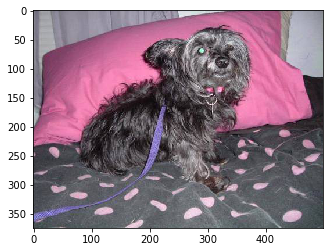

In [323]:
# dog example
sample_img_path = DIR_IMG_TRAIN+'dog.0.jpg'
sample_img = imread(sample_img_path)
plt.imshow(sample_img)
print ('Image have shape: {}'.format(sample_img.shape))

Perrito #0 as image:


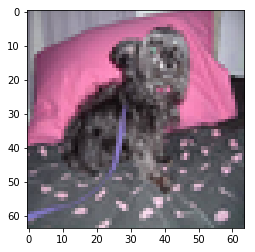

In [324]:
# as long as images have different sizes, let's resize!

def imgResize (img, w, h):
    return img.resize((w,h),Image.ANTIALIAS)

# dog example resized
dog_index = 0
sample_img_path = DIR_IMG_TRAIN+'dog.'+str(dog_index)+'.jpg'
sample_img = np.zeros ((64, 64, 3), dtype=np.uint8)
sample_img = imgResize (Image.open(sample_img_path), 64, 64)
plt.imshow(sample_img)
print ('Perrito #'+str(dog_index)+' as image:')

In [555]:
def getLabel (X):
    """
    Return the label for an element based on the filename: 
        dog -> 0 
        cat -> 1
    """
    if ('dog' in X):
        return 0
    else:
        return 1
    
def getLabels (X):
    """
    Returns an array with the labels foreach file
    """
    result = np.zeros(len(X),dtype=np.int)
    for i in range(0,len(X)):
        result[i] = getLabel(X[i])
    return result

def getLabelFromScore (score):
    """
    Returns the label based on the probability
    if score <= 0.5, return 'dog'
    else return 'cat'
    """
    if (score <=0.5):
        return 'dog'
    else:
        return 'cat'

In [664]:
train_imgs = os.listdir(DIR_IMG_TRAIN)

split_train = 0.3
split_dev = 0.05

split_train_idx = int(len(train_imgs)*split_train)
split_dev_idx = int(len(train_imgs)*split_dev)

train_x = train_imgs[:split_train_idx]
dev_x = train_imgs[split_train_idx:split_train_idx+split_dev_idx]

train_y = getLabels (train_x)
dev_y = getLabels (dev_x)

print ("Number of train examples = "+str(len(train_x)))
print ("Number of train labels = "+str(len(train_y)))

print ("Number of dev examples = "+str(len(dev_x)))
print ("Number of dev labels = "+str(len(dev_y)))

print ("First element of dev set "+dev_x[0])
print ("Label of first element of dev set = "+str(dev_y[0]))

print ("Size of each image = "+str(IMG_SHAPE))

# test ->

split_test_dev = 0.05

split_test_dev_idx = int(len(train_imgs)*split_test_dev)

dev_test_x = train_imgs[split_train_idx+split_dev_idx:split_train_idx+split_dev_idx+split_test_dev_idx]

dev_test_y = getLabels (dev_test_x)

print ("")
print ("")

print ("Number of test dev examples = "+str(len(dev_test_x)))
print ("Number of test dev labels = "+str(len(dev_test_y)))

print ("First element of dev set "+dev_test_x[0])
print ("Label of first element of dev set = "+str(dev_test_y[0]))

Number of train examples = 7500
Number of train labels = 7500
Number of dev examples = 1250
Number of dev labels = 1250
First element of dev set cat.12268.jpg
Label of first element of dev set = 1
Size of each image = (64, 64, 3)


Number of test dev examples = 1250
Number of test dev labels = 1250
First element of dev set dog.11017.jpg
Label of first element of dev set = 0


In [665]:
def normalizedArrayFromImage (image, IMG_SHAPE):
    result = np.array(list(image.getdata()), dtype=np.float32) / 255.
    return result.reshape (IMG_SHAPE)

In [666]:
def loadResizeNormalizeImages (basepath, path_array, img_shape):
    """
    Loads the images from the path 
    and returns them in an array
    """
    images = np.zeros ((len(path_array), img_shape[0], img_shape[1], img_shape[2]), dtype=np.float32)
    for i in range (len(path_array)):
        images[i] = normalizedArrayFromImage (imgResize (Image.open(basepath+path_array[i]), img_shape[0], img_shape[1]), img_shape)
    return images

In [667]:
def getBatches (basepath, array, img_shape, num_of_batches=1, size=16):
    if (num_of_batches*size > len(array)):
        raise ValueError('Batches don''t fit the data.') # TODO: create dynamic batches!
    img_counter = 0
    images = loadResizeNormalizeImages (basepath, array, img_shape)
    batches = np.zeros ((num_of_batches, size, img_shape[0], img_shape[1], img_shape[2]), dtype=np.float32)
    for i in range(num_of_batches):
        for j in range(size):
            if (img_counter < len(images)):
                batches[i][j] = images[img_counter]
                img_counter = img_counter + 1
            else:
                break
    return batches

(1, 2, 64, 64, 3)


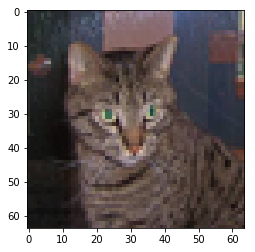

In [668]:
# test getBatches:

pathes = np.array(['cat.1.jpg', 'dog.2.jpg'])
sample_batches = getBatches (DIR_IMG_TRAIN, pathes, IMG_SHAPE, num_of_batches=1, size=2)
print (sample_batches.shape)
plt.imshow(jose2[0][0])

Create the model in Keras

In [669]:
# Keras imports

from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

import keras.backend as K
K.set_image_data_format('channels_last')


In [670]:
def DogsCatsModel(input_shape):
    """
    Implementation of the model.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    
    # input
    X_input = Input (input_shape) # 64x64x3
    
    # conv2d -> BN - RELU
    X = Conv2D (32, (3,3), strides=(2,2), name='conv1')(X_input) # 31x31x32
    # BN
    X = BatchNormalization (axis=3, name='bn0')(X)
    # activation
    X = Activation ('relu')(X)
    print("X after conv2D = "+str(X.shape))
    
    # Maxpool
    X = MaxPooling2D (pool_size=(2,2), name='pool1')(X) # 15x15x32
    print("X after maxpool = "+str(X.shape))

    # conv2d -> BN - RELU
    X = Conv2D (64, (2,2), strides=(1,1), name='conv2')(X) # 14x14x64
    X = BatchNormalization (axis=3, name='bn1')(X)
    X = Activation ('relu')(X)
    print("X after conv2D = "+str(X.shape))
    
    # Maxpool
    X = MaxPooling2D (pool_size=(2,2), name='pool2')(X) # 7x7x64
    print("X after maxpool = "+str(X.shape))

    # conv2d -> BN - RELU
    X = Conv2D (128, (2,2), strides=(2,2), name='conv3')(X) # 3x3x128
    X = BatchNormalization (axis=3, name='bn2')(X)
    X = Activation ('relu')(X)
    print("X after conv2D = "+str(X.shape))

    X = ZeroPadding2D ((1,1))(X) # 5x5x128
    print("X after padding = "+str(X.shape))

    # conv2d -> BN - RELU
    X = Conv2D (256, (2,2), strides=(1,1), name='conv4')(X) # 4x4x256
    X = BatchNormalization (axis=3, name='bn3')(X)
    print("X after conv2D = "+str(X.shape))   

    # Flatten
    X = Flatten ()(X)
    
    print("X after flatten = "+str(X.shape))
    
    # FC1
    X = Dense (1024, activation='relu', name='fc1')(X)
    X = Dropout (0.5)(X)
    # FC2
    X = Dense (512, activation='relu', name='fc2')(X)
    X = Dropout (0.5)(X)
    # FC2
    X = Dense (256, name='fc3')(X)
    X = Dropout (0.5)(X)
    # Final FC
    X = Dense (1, activation='sigmoid', name='fc4')(X)

    # model
    model = Model (inputs=X_input, outputs=X, name='DogsCatsModel')
        
    return model

In [671]:
dogsCatsModel = DogsCatsModel ((64,64,3))

X after conv2D = (?, 31, 31, 32)
X after maxpool = (?, 15, 15, 32)
X after conv2D = (?, 14, 14, 64)
X after maxpool = (?, 7, 7, 64)
X after conv2D = (?, 3, 3, 128)
X after padding = (?, 5, 5, 128)
X after conv2D = (?, 4, 4, 256)
X after flatten = (?, ?)


In [672]:
dogsCatsModel.compile (optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Train the model

In [681]:
# prepare the data
img_dev_x = loadResizeNormalizeImages (DIR_IMG_TRAIN, dev_x, IMG_SHAPE)
print (img_dev_x.shape)

#prepare test data
img_dev_test_x = loadResizeNormalizeImages (DIR_IMG_TRAIN, dev_test_x, IMG_SHAPE)
print (img_dev_test_x.shape)

# % dogs vs cats
cats = 0
dogs = 0
for i in range(len(dev_y)):
    if (dev_y[i] == 0):
        dogs = dogs + 1
    else:
        cats = cats + 1

cats_percent = (cats/len(dev_y))*100.0
dogs_percent = 100.0 - cats_percent
print ("Cats represent "+str(cats_percent)+"% of the total")
print ("Dogs represent "+str(dogs_percent))

(1250, 64, 64, 3)
(1250, 64, 64, 3)
Cats represent 48.559999999999995% of the total
Dogs represent 51.440000000000005


In [675]:
dogsCatsModel.fit (x=img_dev_x, y=dev_y, batch_size=16, epochs=5)

Epoch 1/5
1250/1250 [==============================] - 12s 10ms/step - loss: 2.8069 - acc: 0.5656
Epoch 2/5
1250/1250 [==============================] - 9s 7ms/step - loss: 1.4150 - acc: 0.5808
Epoch 3/5
1250/1250 [==============================] - 9s 7ms/step - loss: 1.0192 - acc: 0.6032
Epoch 4/5
1250/1250 [==============================] - 9s 7ms/step - loss: 0.7493 - acc: 0.6504
Epoch 5/5
1250/1250 [==============================] - 9s 7ms/step - loss: 0.6654 - acc: 0.6800


Evaluate

In [676]:
preds = dogsCatsModel.evaluate (x=img_dev_test_x, y=dev_test_y, batch_size=16)
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

1250/1250 [==============================] - 3s 2ms/step

Loss = 0.611268408346
Test Accuracy = 0.68


It's a cat!


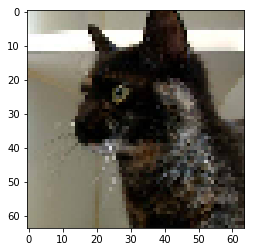

In [678]:
img_path = DIR_IMG_TEST+'5.jpg'
img = image.load_img(img_path, target_size=(64, 64))
imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

score = dogsCatsModel.predict(x)
print("It's a "+getLabelFromScore (score)+"!")

In [663]:
dogsCatsModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 31, 31, 32)        896       
_________________________________________________________________
bn0 (BatchNormalization)     (None, 31, 31, 32)        128       
_________________________________________________________________
activation_75 (Activation)   (None, 31, 31, 32)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 64)        8256      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 14, 14, 64)        256       
__________